# Sleep Prediction
Here we try to use environemntal parameter in addition to mood characteristics to see if we are able to predict sleep quality.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
    1. Fitbit Sleep
    2. Self-Report Sleep (Beiwe App)
    3. IEQ (BEVO Beacon)
    4. Mood (Beiwe App)
2. [Summary and Feature/Target Identification](#summary)
    1. Feature: IEQ
    2. Feature: Mood
    3. Target: Fitbit Sleep
    4. Target: Self-Report Sleep
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness

<a id="data-import"></a>

# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ and mood data.

### Fitbit Sleep Summary
The data included are all possible observations of sleep measurements. The data has **not** been altered from its original state recorded by Fitbit, but a few new variables have been defined:

* `nrem`: We have defined a aggregated value for `light`+`deep` sleep recorded by Fitbit in order to improve the accuracy of our sleep measurements. We include both a `count`, `minutes`, and `percent` metric for this variable referencing the number of times the participant transitioned into that state, the total amount of minutes per night spent in that state, and the percentage of the TST was spent in the state, respectively.
* `rem2nrem`: This new variable represents the ratio of time spent in REM sleep to the newly defined `nrem` sleep. 
* `waso`: Acronym for Wake After Sleep Onset and refers to the amount of time (in minutes) spent awake after initially falling asleep. Calculated by multiplying the TST by (1 - sleep efficiency) - efficiency does not take the initial sleep period into account. 
* `sol`: Acronym got Sleep Onset Latency and refers to the amount of time it takes for the participant to fall asleep. Calculated by taking the `wake_minutes` measured by Fitbit and subtracting the newly calculated `waso`. 

In [3]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)#,index_col=["beiwe","start_time"])
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,297,0.276094,6.766667,0.201970,0.731527,12.18,14.82
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,345,0.136232,8.216667,0.095335,0.699797,64.09,36.91
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,237,0.210970,5.483333,0.151976,0.720365,16.45,25.55
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,320,0.259375,7.450000,0.185682,0.715884,17.88,26.12
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,263,0.334601,6.933333,0.211538,0.632212,33.28,31.72


### Self-Report Sleep
Again, all the data from the morning EMA adminisited by Beiwe is included. Since the sleep questions were curated for this study, now new variables are defined from these.

In [4]:
bw_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
bw_sleep["date"] = pd.to_datetime(bw_sleep["timestamp"].dt.date)
bw_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon,date
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0,2020-05-13
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0,2020-05-13
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0,2020-05-13
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN,2020-05-13
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN,2020-05-13


### Beacon IAQ
The BEVO Beacon data that is included corresponds to nights when Fitbit has detected a sleep event and `gps` data from Beiwe confirms that the participant is home. Since the beacon data is the most restricted and includes all of our (most) relevant features, we can use this dataset to subset the sleep target datasets. 

In [5]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw.drop([c for c in ieq_raw.columns if c.endswith("percent") or c.endswith("mean")],axis="columns",inplace=True)
for bad_label in ["long","lat","accuracy","altitude","pm1","number"]:
    ieq_raw.drop([c for c in ieq_raw.columns if c.startswith(bad_label)],axis="columns",inplace=True)

ieq = ieq_raw.copy()
ieq["date"] = pd.to_datetime(ieq["end_time"].dt.date)
ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,date
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,33.0,91.90,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000,0.950,2020-08-10
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,34.0,160.45,0.204,NaN,5.565250,202.651343,6.086460,0.665257,1.650,2.000,2020-08-11
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,33.0,108.60,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000,1.500,2020-08-12
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,33.0,81.80,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175,1.250,2020-08-14
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,34.0,149.30,0.136,NaN,0.684917,125.544723,43.415611,2.880943,1.000,2.575,2020-08-15


### Beiwe Mood
Mood data as reported by participants on the EMAs.

In [6]:
bw_mood = pd.read_csv("../data/processed/beiwe-daily_ema-ux_s20.csv",parse_dates=["date","timestamp_morning","timestamp_evening"],infer_datetime_format=True)
bw_mood.head()

,timestamp_morning,beiwe,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,redcap,beacon,date,timestamp_evening,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,content_mean,stress_mean,lonely_mean,sad_mean,energy_mean
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0,2020-05-13,2020-05-13 21:00:18,3.0,1.0,0.0,0.0,4.0,3.0,0.5,0.0,0.0,2.5
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0,2020-05-13,2020-05-13 19:00:23,1.0,1.0,1.0,3.0,2.0,1.0,1.5,1.0,2.0,1.5
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0,2020-05-13,2020-05-13 20:07:04,1.0,3.0,1.0,2.0,0.0,1.0,2.0,1.0,2.5,0.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN,2020-05-13,2020-05-13 19:30:38,2.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.5,0.5
4,2020-05-13 12:30:38,lkkjddam,1,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0,12,21.0,2020-05-13,2020-05-13 19:21:32,0.0,2.0,3.0,1.0,0.0,0.0,1.5,3.0,2.0,1.0


<a id="summary"></a>

# Data Summary and Feature/Target Identification
The primary features are related to the IEQ dataset measured by the BEVO Beacons while the primary targets are both the Fitbit-measured and self-reported sleep quality metrics. However some features might be more or less pertinent than others. In these sections we summarize the data and identify which are the important variables to include in the subsequent analysis.

## Feature Identification
We start with the features which consist primarily from the IEQ dataset, but might also include data from the mood EMAs. 

In [7]:
def plot_pollutant(df,pollutant="co2"):
    """plots median and delta concentrations of the given pollutant"""
    fig, axes = plt.subplots(1,2,figsize=(24,3),gridspec_kw={"wspace":0.1})
    for aggregate, ax in zip(["median","delta"],axes.flat):
        sns.kdeplot(df[f"{pollutant}_{aggregate}"],cut=0,linewidth=2,color="black",ax=ax)
        # improving graph
        for loc in ["left","top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_xlabel(aggregate.title() + " " + visualize.get_pollutant_label(pollutant))
        ax.set_yticks([])
        ax.set_ylabel("")

    plt.show()
    plt.close()

### IEQ Data
There are a few pollutants and environmental parameters that we can consider:
1. CO$_2$
2. CO
3. PM$_{2.5}$ (mass)
3. PM$_{2.5}$ (number)
4. NO$_2$
5. TVOCs
6. Temperature
7. RH

And two main aggregates to summarize the evening:
1. Median (more typical in IAQ field versus mean)
2. Delta

The following cells will try to determine to what features are good candidates, both aggregates and pollutants.

In [8]:
pollutants_for_consideration = ["co2","co","pm2p5_mass","pm2p5_number","no2","tvoc"]
print("Number of observations:")
for pollutant in pollutants_for_consideration:
    print(f"\t{visualize.get_pollutant_label(pollutant):<10s} {len(ieq[f'{pollutant}_median'].dropna())}")

Number of observations:
	CO$_2$     332
	CO         332
	PM$_{2.5}$ 318
	PM$_{2.5}$ 318
	NO$_2$     139
	TVOC       331


#### CO$_2$
Carbon dioxide is implicated in nearly all studies relating IAQ and sleep quality, is one of the most robust sensors on the beacon, and can be used as a proxy for other pollutants.

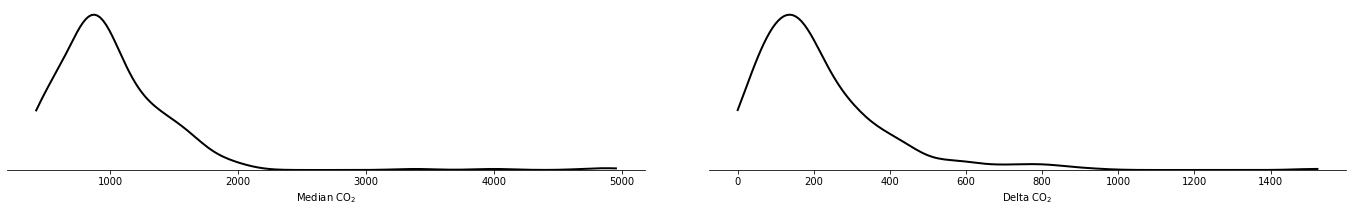

In [9]:
plot_pollutant(ieq,"co2")

<div class="alert alert-block alert-success">
 
CO$_2$ is a good candidate pollutant to include because of its history in the field.
    
</div>

#### CO
We start by plotting all the measured values.

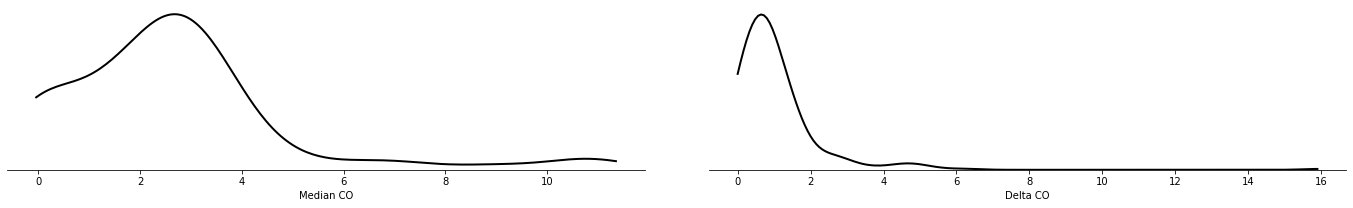

In [10]:
plot_pollutant(ieq,"co")

<div class="alert alert-block alert-success">
 
CO, while the measurements are slightly elevated from what is typically found in apartments (see [Jo and Lee, 2016](https://www.sciencedirect.com/science/article/pii/S1352231006005176?casa_token=htmTQdXyFpYAAAAA:rsTEojfxlUHuYI7AlBt5I16TZSsbc2t2Wyd-Wd9sAg6TR7RGzs1XLeaI50udw1NU10BIUhXA)), is still a good candidate since we are primarily concerned with how changes in concentration might affect sleep quality, not the accuracy of our measurements.
    
</div>

#### PM$_{2.5}$
We consider both number and mass here and start by examining the relationship between the two

In [11]:
def plot_correlation(df_in,x="pm2p5_mass",x_agg="",y="pm2p5_number",y_agg=""):
    """Plots the correlation between two measurements"""
    df = df_in[[f"{x}{x_agg}",f"{y}{y_agg}"]].dropna()
    fig, ax = plt.subplots(figsize=(4,4))
    sns.regplot(x=f"{x}{x_agg}",y=f"{y}{y_agg}",data=df,ax=ax)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    ax.set_xlabel(f"{visualize.get_label(x)} ({visualize.get_pollutant_units(x)})")

    ax.set_ylabel(f"{visualize.get_label(y)} ({visualize.get_pollutant_units(y)})")

    r = np.corrcoef(df[f"{x}{x_agg}"].values,df[f"{y}{y_agg}"].values)
    ax.set_title(f"r$^2$: {round(r[1,0],2)}")

    plt.show()
    plt.close()

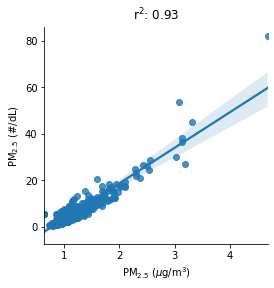

In [12]:
plot_correlation(ieq,x="pm2p5_mass",x_agg="_median",y="pm2p5_number",y_agg="_median")

<div class="alert alert-block alert-success">
 
PM$_{2.5}$ (mass), like CO$_2$ has been implicated in multiple studies to affect sleep quality and we can also _more_ readily trust the measurements from this sensor therefore this measurement is a good candidate. 
    
</div>

<div class="alert alert-block alert-danger">
 
PM$_{2.5}$ (number) is an important variable to measure but has a significant correlation with the mass concentration. Rather than complicate the model with an additional feature, we can remove this one in favor of simplifying the model. The mass concentration is also easier to converse about rather than the number concentration. 
    
</div>

#### NO$_2$
A promising, new candidate. We start by visualizing the data we have.

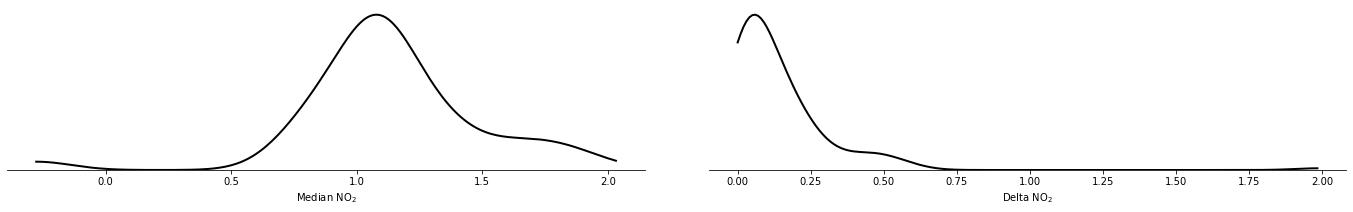

In [13]:
plot_pollutant(ieq,"no2")

<div class="alert alert-block alert-danger">
 
There are a few reasons not to include the NO$_2$ measurements:
* We have a limited number of observations
* There are negative values present after calibration
* The measured differences are less than 1 ppb. Those different are _highly_ unlikely to be noticed by the human body.
    
</div>

#### TVOC
TVOCs are already a controversial pollutant to include, but we can start by visualizing the measured concentrations.

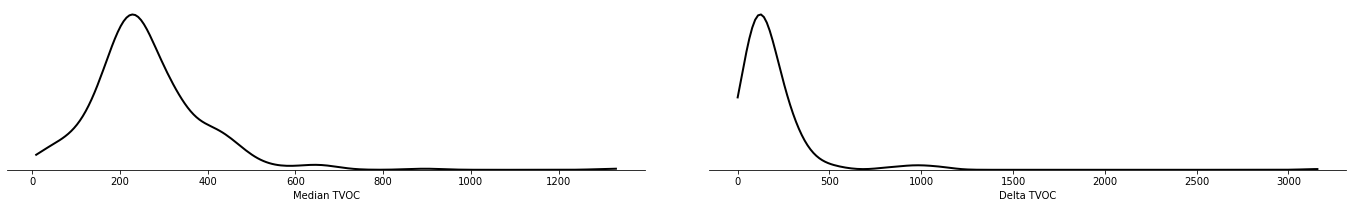

In [14]:
plot_pollutant(ieq,"tvoc")

<div class="alert alert-block alert-success">
 
These values seem reasonable given similar measurements made in the literature so we can include TVOCs as a potential candidate. 
    
</div>

#### Temperature and Relative Humidity
Often taken together, we consider both here.

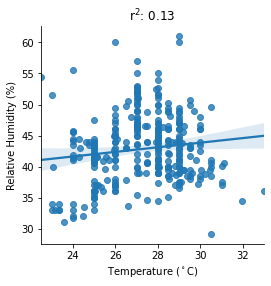

In [15]:
plot_correlation(ieq,x="temperature_c",x_agg="_median",y="rh",y_agg="_median")

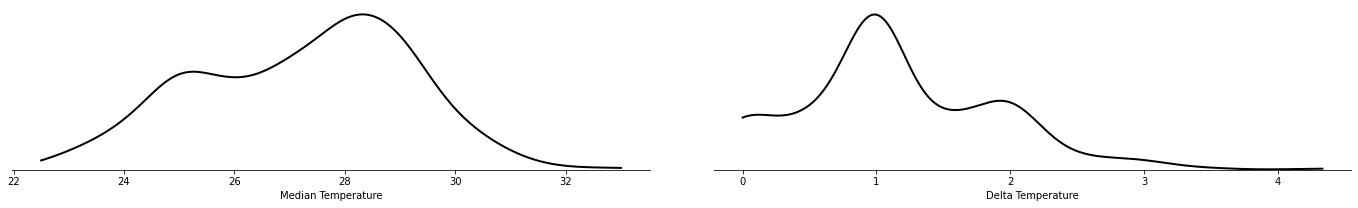

In [16]:
plot_pollutant(ieq,"temperature_c")

<div class="alert alert-block alert-success">
 
Although our temperatures are probably 1 or 2$^\circ$C higher than normal, they are still in a decent range and temperature is an important component of sleep quality so we should include it. 
    
</div>

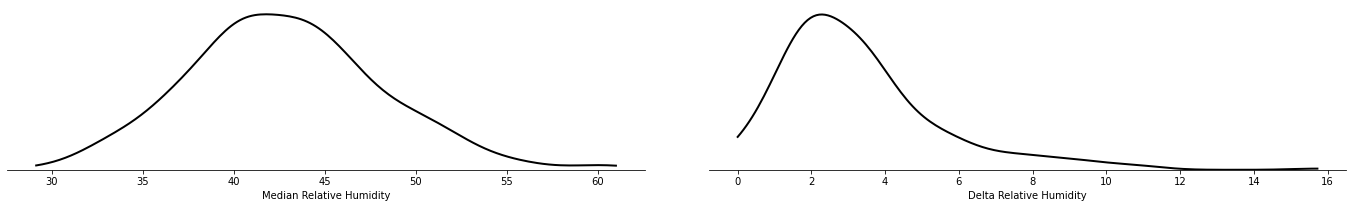

In [17]:
plot_pollutant(ieq,"rh")

<div class="alert alert-block alert-success">
 
Relative Humidity, unlike temperature, is a bit lower than expected by 5-10% assuming 50% is common in indoor environments during summer. However, we should also include this metric since it might be key in determining sleep quality.
    
</div>

#### Median vs Delta
Both aggregates for pollutant measurements seem viable, but both are not necessary for prediction. While the increase in concentration during the night is likely to induce changes in participant behavior, the median value might capture large deltas.

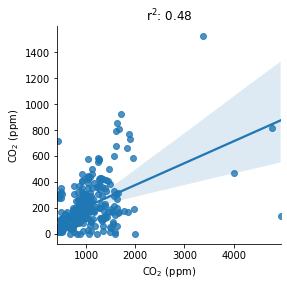

In [18]:
plot_correlation(ieq,x="co2",x_agg="_median",y="co2",y_agg="_delta")

The two aggregates are actually not highly correlated which is surprising.

<div class="alert alert-block alert-danger">
 
The delta metric, while insightful, has values that seem skewed high so we will not use them. This aggregate needs to be refined a bit more. 
    
</div>

<div class="alert alert-block alert-success">
 
Median will be the only aggregate for IEQ parameters that we will consider which will also help simplify our model a bit. 
    
</div>

#### Raw Feature Set
Based on the commentary above, we will reconfigure the IEQ data set.

In [19]:
ieq_features = ieq.copy()
# id columns to drop
id_cols = ["redcap","fitbit","beacon"]
# bad ieq params
ieq_cols = ["pm2p5_number_median","lux_median","no2_median"]
# delta agg
delta_cols = [column for column in ieq.columns if column.endswith("delta")]
# dropping
for cols in [id_cols,ieq_cols,delta_cols]:
    ieq_features.drop(cols,axis="columns",inplace=True)
    
ieq_features.head()

,start_time,end_time,beiwe,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,date
0,2020-08-10 04:42:30,2020-08-10 12:35:30,lkkjddam,126.658333,10.359917,1600.754959,0.895571,23.337500,33.0,2020-08-10
1,2020-08-11 03:35:00,2020-08-11 12:36:30,lkkjddam,233.566667,6.429275,1628.474180,0.847762,25.000000,34.0,2020-08-11
2,2020-08-12 02:59:30,2020-08-12 10:52:30,lkkjddam,252.016667,10.271850,1596.122408,0.939256,24.000000,33.0,2020-08-12
3,2020-08-14 03:05:00,2020-08-14 11:23:30,lkkjddam,223.700000,7.232700,1301.449844,0.886675,25.000000,33.0,2020-08-14
4,2020-08-15 06:51:30,2020-08-15 11:30:00,lkkjddam,209.600000,10.886100,1274.110350,1.046326,23.333333,34.0,2020-08-15


<div class="alert alert-block alert-info">

We are keeping the time and `beiwe` columns so that we can merge datasets later.
    
</div>

### Mood
While not the main feature to include, there might be components of mood that are relevant for sleep, primarily:
1. content
2. stress
3. energy
4. sad

The mood scores we use should be those from the nightly EMAs filled out the night prior to the sleep event. These data have already been processed and are imported here. The process is not as straightforward since the participant might fill the EMA out around 21:00 on Day 1 but sleep at 1:00 on Day 2. That EMA would consist of data relevant for the sleep event that happened in the early morning. The process of investigating situations like these have already been completed and included in the following dataset.

In [20]:
mood_evening = pd.read_csv("../data/processed/beiwe_fitbit-evening_mood_and_sleep-ux_s20.csv",
                          parse_dates=["start_time","end_time","end_date"],infer_datetime_format=True)
print(f"Number of observations:", len(mood_evening))

Number of observations: 736


In [21]:
def plot_mood_bar(df, mood="content",annotate=True):
    """Creates a bar plot for the given mood"""
    
    df_to_plot = df[mood]
    fig, ax = plt.subplots(figsize=(8,3))
    ns = dict(df[mood].value_counts())
    ax.bar(ns.keys(),ns.values(),color="cornflowerblue",edgecolor="black")
    # x-axis
    ax.set_xticks(list(ns.keys()))
    ax.set_xticklabels(list(ns.keys()),fontsize=12)
    ax.set_xlabel(mood.replace("_"," ").title(),fontsize=14)
    # y-axis
    plt.yticks(fontsize=12)
    ax.set_ylabel("Count",fontsize=14)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    if annotate:
        for score, n in ns.items():
            ax.text(score,n*1.1,n,ha="center",va="bottom",fontsize=12)

#### Content

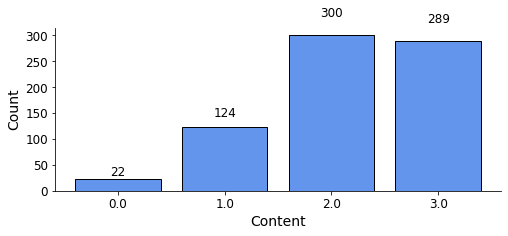

In [22]:
plot_mood_bar(mood_evening)

#### Stress

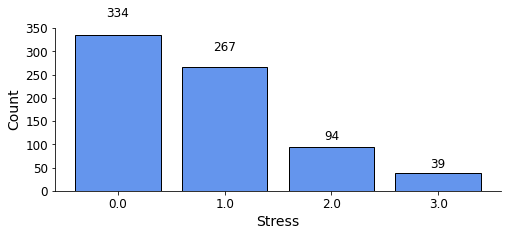

In [23]:
plot_mood_bar(mood_evening,"stress")

#### Energy

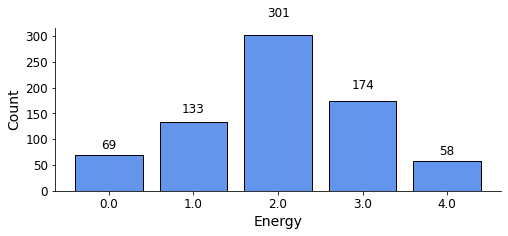

In [24]:
plot_mood_bar(mood_evening,"energy")

#### Sad

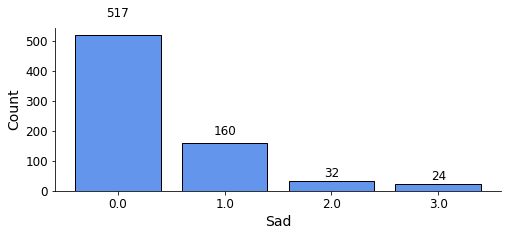

In [25]:
plot_mood_bar(mood_evening,"sad")

<div class="alert alert-block alert-success">
 
There isn't any reason not to include these mood metrics, but we might engineering them slightly in the later cells to get them into a more ueful measure. 
    
</div>

#### Raw Feature Set
Subsetting the original dataset for the important mood measurements.

In [26]:
mood_features = mood_evening.copy()
mood_features = mood_features[["start_time","end_time","end_date","beiwe","content","stress","sad","energy"]]
mood_features.head()

,start_time,end_time,end_date,beiwe,content,stress,sad,energy
0,2020-07-21 00:20:30,2020-07-21 07:16:00,2020-07-21,hcpu5myv,2.0,2.0,1.0,1.0
1,2020-05-16 04:35:00,2020-05-16 13:10:00,2020-05-16,lkkjddam,0.0,1.0,3.0,0.0
2,2020-05-18 03:35:00,2020-05-18 13:12:30,2020-05-18,lkkjddam,0.0,0.0,3.0,0.0
3,2020-05-19 02:01:00,2020-05-19 09:19:30,2020-05-19,lkkjddam,1.0,1.0,1.0,2.0
4,2020-05-21 02:32:00,2020-05-21 10:54:30,2020-05-21,lkkjddam,2.0,1.0,2.0,2.0


<div class="alert alert-block alert-info">

Again we keep some of the time columns and the `beiwe` column for merging with other datasets.
    
</div>

## Target Identification
The primary target variables are going to be those associated with sleep. 

### Fitbit-Monitored Sleep
There is quite a bit of sleep-related information from Fitbit, raw or otherwise. Here we look at the various variables to see which is important for sleep prediction. The variables we are interested in, at least initially, are:
1. efficiency
2. REM:nREM
3. TST
4. REM
5. nREM
6. WASO
7. SOL

We also want to explore this relationship between the `count` and the `minutes` measurements to see how strong the relationship is and whether or not included the `count` measurements make sense.

In [27]:
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,297,0.276094,6.766667,0.201970,0.731527,12.18,14.82
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,345,0.136232,8.216667,0.095335,0.699797,64.09,36.91
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,237,0.210970,5.483333,0.151976,0.720365,16.45,25.55
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,320,0.259375,7.450000,0.185682,0.715884,17.88,26.12
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,263,0.334601,6.933333,0.211538,0.632212,33.28,31.72


#### Efficiency, TST, WASO, SOL
These metrics are used time and time again in the sleep literature and help to fully understand multiple aspects of a person's sleep.

<div class="alert alert-block alert-success">
 
These variables (Efficiency, TST, WASO, SOL) are automatically included because of their relevance in the sleep world.
    
</div>

#### REM, nREM, REM:nREM
I think there is merit including all three of these variables since although the ratio might capture a lot of the behavior.

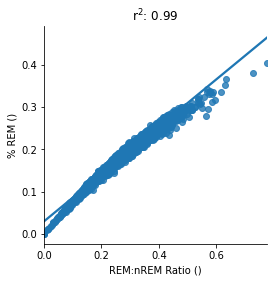

In [28]:
plot_correlation(fb_sleep,x="rem2nrem",y="rem_percent")

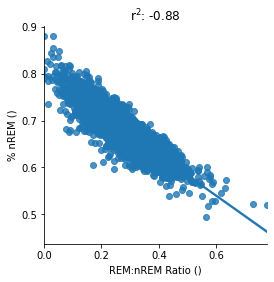

In [29]:
plot_correlation(fb_sleep,x="rem2nrem",y="nrem_percent")

<div class="alert alert-block alert-danger">
 
The REM:nREM ratio is heavily correlated with both the REM and nREM percentage. Rather than include all three, we can just consider the ratio.
    
</div>

<div class="alert alert-block alert-success">
 
REM:nREM ratio will help to provide a look at the sleep stages that are often omitted from similar studies. 
    
</div>

#### Count vs Minutes
There should be a relationship between the `count` and `minutes` for each stage measured by Fitbit, but not necessarily all the time. A participant could have been trasnitioning in and out of different states a lot which would increase the `count`, but not necessarily the `minutes` relative to a normal night.

wake


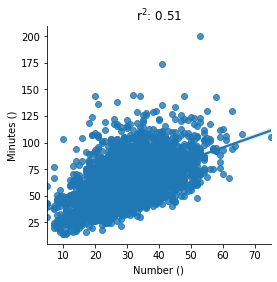

rem


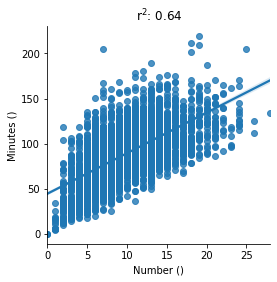

nrem


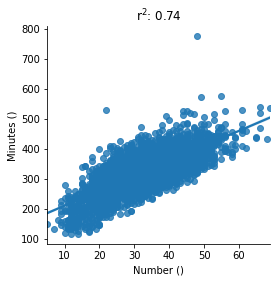

In [30]:
for stage in ["wake","rem","nrem"]:
    print(stage)
    plot_correlation(fb_sleep,x=f"{stage}_count",y=f"{stage}_minutes")

<div class="alert alert-block alert-success">
 
The relationship between count and minutes is not _very_ strong, but still apparent based on the figures above.
    
</div>

<div class="alert alert-block alert-danger">
 
Both `count` and `minutes` are TST-dependent i.e. the longer the participant sleeps, the larger the number of `count` and `minutes` for the various stages (for the most part). The other metrics, for the most part, are not sleep length dependent.  
    
</div>

#### Raw Data Set
Lot of variables to remove here.

In [31]:
fb_targets = fb_sleep.copy()
# id and time cols
id_cols = ["start_date","redcap","beacon"]
# bad sleep params
bad_params = [column for column in fb_sleep.columns if column.endswith("count") or column.endswith("percent") or column.endswith("minutes")]
for cols in [id_cols,bad_params]:
    fb_targets.drop(cols,axis="columns",inplace=True)

fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72


### Self-Report Sleep
The self-report sleep metrics will be easy since we will simply include all of them in the analysis. The sleep metrics that _will_ be used are:
1. SOL
2. NAW
3. TST
4. Restfulness

#### Raw Data Set
The sleep EMA has mood data that we do not need and some id/time columns.

In [32]:
bw_targets = bw_sleep.copy()
bw_targets = bw_targets[["date","beiwe","tst","sol","naw","restful"]]
bw_targets.head()

,date,beiwe,tst,sol,naw,restful
0,2020-05-13,qh34m4r9,8.0,20.0,2.0,3.0
1,2020-05-13,awa8uces,2.0,10.0,3.0,1.0
2,2020-05-13,xxvnhauv,6.0,30.0,3.0,1.0
3,2020-05-13,rvhdl2la,5.3,5.0,2.0,2.0
4,2020-05-13,q5y11ytm,2.0,10.0,0.0,0.0


<a id="encoding" ></a>

# Target Encoding
A few of the targets could do with a bit of encoding to simplify them. In particular:

**Fitbit**
* **Efficiency**: A few of the efficiency scores are _very_ low and rather than deal with this metric on a continuous scale, we can define values on a scale based on traditional understanding of sleep efficiency to cope with these disparities.
* **TST**: Rather than trying to look at TST on a continuous scale, we can simplify the problem by looking at low, typical/recommended/ and high `tst`.
* **SOL**: Based on Zoltan's recommendations, it is best to go with categorical targets rather than continuous.

**Beiwe**
* **Restful**: Discerning between the scales of the restful score is a bit tricky so we group the restful scores into two categories: 0 for overall negative and 1 for overall positive.
* **SOL**: Many of the participants tend to answer with similar times so we can group them.
* **NAW**: The `naw` responses are almost categorized into bins, but there are too many. We can simplify the problem by looking at binary indicators.

## Fitbit Sleep Metrics
We start encoding the continuous targets to categorical by looking at the Fitbit-measured sleep metrics.

### Efficiency - Recommendations
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |

In [33]:
def rate_se(value):
    """returns encoded value for se"""
    if value > 90:
        return 3
    elif value > 85:
        return 2
    elif value > 80:
        return 1
    else:
        return 0

In [34]:
try:
    fb_targets["se_rating"] = fb_targets.apply(lambda x: rate_se(x["efficiency"]), axis="columns")
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3


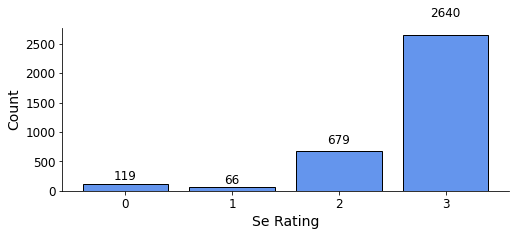

In [35]:
plot_mood_bar(fb_targets,"se_rating")

### Efficiency - Binary
Since `se` is heavily skewed towards higher percentages, we can group them into binary categories. We will base the categories off of "excellent" scores (>90) and all others.

In [217]:
try:
    fb_targets["se_binary"] = [1 if eff > 93 else 0 for eff in fb_targets["efficiency"]]
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary,rem2nrem_binary
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3,1,0,1,1,1
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2,0,1,0,0,0
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3,1,0,1,1,1
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3,1,1,1,1,1
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3,0,0,0,1,1


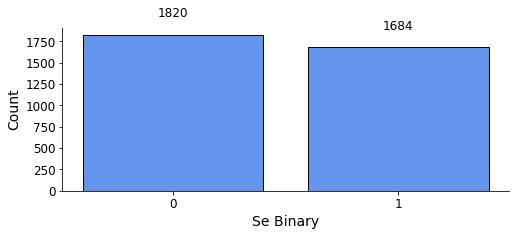

In [218]:
plot_mood_bar(fb_targets,"se_binary")

### TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 2 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [38]:
def rate_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 2
    elif value >= 7:
        return 1
    else:
        return 0

In [39]:
try:
    fb_targets["tst_rating"] = fb_targets.apply(lambda x: rate_tst(x["tst_fb"]), axis="columns")
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3,1,0
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2,0,1
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3,1,0
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3,1,1
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3,1,0


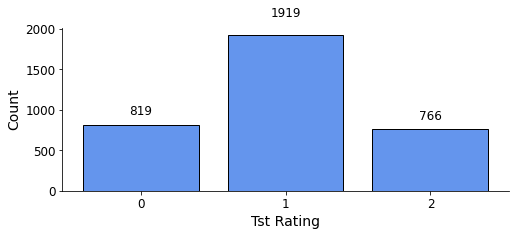

In [40]:
plot_mood_bar(fb_targets,"tst_rating")

### SOL
Sleep onset latency can be group into two bins according to:

| SOL | Rating | Value |
| --- | --- | --- |
| >30 mins | High | 0 |
| <30 | Ideal | 1 |

In [41]:
try:
    fb_targets["sol_binary"] = [0 if sl >= 30 else 1 for sl in fb_targets["sol_fb"]]
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3,1,0,1
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2,0,1,0
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3,1,0,1
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3,1,1,1
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3,1,0,0


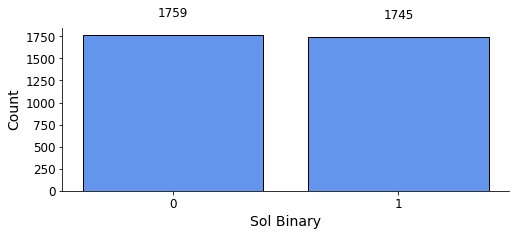

In [140]:
plot_mood_bar(fb_targets,"sol_binary")

### WASO
Based on the same article, the `waso` can be binned into two categories based on:

| SOL | Rating | Value |
| --- | --- | --- |
| >40 mins | High | 0 |
| <40 | Ideal | 1 |

In [43]:
try:
    fb_targets["waso_binary"] = [0 if t > 40 else 1 for t in fb_targets["waso"]]
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3,1,0,1,1
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2,0,1,0,0
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3,1,0,1,1
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3,1,1,1,1
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3,1,0,0,1


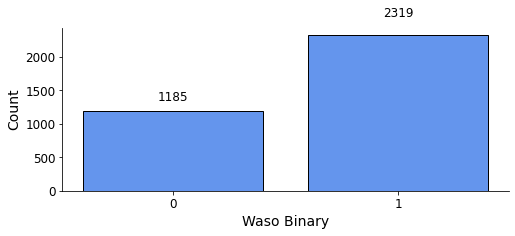

In [44]:
plot_mood_bar(fb_targets,"waso_binary")

### REM:nREM

In [45]:
def rate_rem2nrem(value):
    """returns score of sol"""
    if value > 0.4:
        return 0
    elif value >= 0.2:
        return 1
    else:
        return 0

In [46]:
try:
    fb_targets["rem2nrem_binary"] = fb_targets.apply(lambda x: rate_rem2nrem(x["rem2nrem"]), axis="columns")
except KeyError:
    print("Encoding already complete")
fb_targets.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary,rem2nrem_binary
0,2020-05-14,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,0.276094,6.766667,12.18,14.82,3,1,0,1,1,1
1,2020-05-15,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,0.136232,8.216667,64.09,36.91,2,0,1,0,0,0
2,2020-05-16,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,0.210970,5.483333,16.45,25.55,3,1,0,1,1,1
3,2020-05-17,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,0.259375,7.450000,17.88,26.12,3,1,1,1,1,1
4,2020-05-18,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,0.334601,6.933333,33.28,31.72,3,1,0,0,1,1


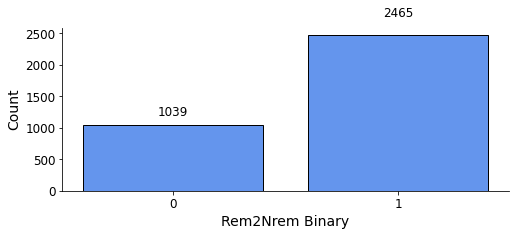

In [47]:
plot_mood_bar(fb_targets,"rem2nrem_binary")

## Beiwe/Self-Report Sleep Metrics
And now on to these metrics.

### TST

In [48]:
try:
    bw_targets["tst_binary"] = [1 if t > 7 else 0 for t in bw_targets["tst"]]
except KeyError:
    print("Encoding already complete")
bw_targets.head()

,date,beiwe,tst,sol,naw,restful,tst_binary
0,2020-05-13,qh34m4r9,8.0,20.0,2.0,3.0,1
1,2020-05-13,awa8uces,2.0,10.0,3.0,1.0,0
2,2020-05-13,xxvnhauv,6.0,30.0,3.0,1.0,0
3,2020-05-13,rvhdl2la,5.3,5.0,2.0,2.0,0
4,2020-05-13,q5y11ytm,2.0,10.0,0.0,0.0,0


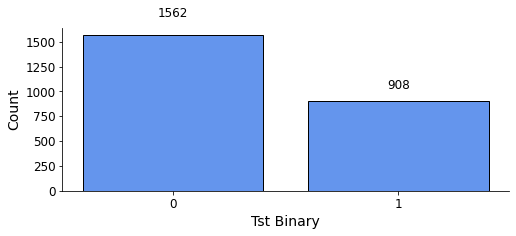

In [49]:
plot_mood_bar(bw_targets,"tst_binary")

### Restful
We will simply take the two lower scores and group into a `0` bin and the two higher scores into a `1` bin.

In [50]:
try:
    bw_targets["restful_binary"] = [0 if score < 2 else 1 for score in bw_targets["restful"]]
    bw_targets.drop(["restful"],axis="columns",inplace=True)
except KeyError:
    print("Encoding already complete")
bw_targets.head()

,date,beiwe,tst,sol,naw,tst_binary,restful_binary
0,2020-05-13,qh34m4r9,8.0,20.0,2.0,1,1
1,2020-05-13,awa8uces,2.0,10.0,3.0,0,0
2,2020-05-13,xxvnhauv,6.0,30.0,3.0,0,0
3,2020-05-13,rvhdl2la,5.3,5.0,2.0,0,1
4,2020-05-13,q5y11ytm,2.0,10.0,0.0,0,0


<a id="feature_engineering"></a>

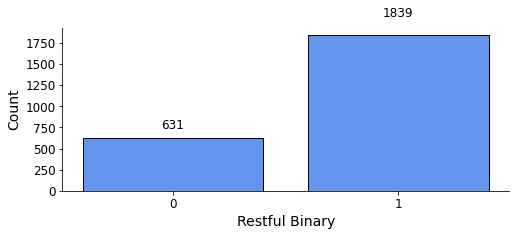

In [51]:
plot_mood_bar(bw_targets,"restful_binary")

### SOL
Similar to how we handled `sol` for Fitbit, we can do the same for Beiwe.

In [52]:
try:
    bw_targets["sol_binary"] = [0 if sl >= 30 else 1 for sl in bw_targets["sol"]]
except KeyError:
    print("Encoding already complete")
bw_targets.head()

,date,beiwe,tst,sol,naw,tst_binary,restful_binary,sol_binary
0,2020-05-13,qh34m4r9,8.0,20.0,2.0,1,1,1
1,2020-05-13,awa8uces,2.0,10.0,3.0,0,0,1
2,2020-05-13,xxvnhauv,6.0,30.0,3.0,0,0,0
3,2020-05-13,rvhdl2la,5.3,5.0,2.0,0,1,1
4,2020-05-13,q5y11ytm,2.0,10.0,0.0,0,0,1


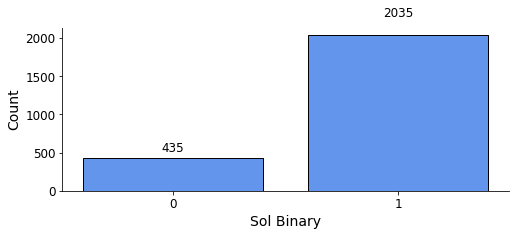

In [53]:
plot_mood_bar(bw_targets,"sol_binary")

### NAW
The `naw` are heavily skewed towards low number of awakenings so we group them into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [54]:
try:
    bw_targets["naw_binary"] = [0 if n > 1 else 1 for n in bw_targets["naw"]]
except KeyError:
    print("Encoding already complete")
bw_targets.head()

,date,beiwe,tst,sol,naw,tst_binary,restful_binary,sol_binary,naw_binary
0,2020-05-13,qh34m4r9,8.0,20.0,2.0,1,1,1,0
1,2020-05-13,awa8uces,2.0,10.0,3.0,0,0,1,0
2,2020-05-13,xxvnhauv,6.0,30.0,3.0,0,0,0,0
3,2020-05-13,rvhdl2la,5.3,5.0,2.0,0,1,1,0
4,2020-05-13,q5y11ytm,2.0,10.0,0.0,0,0,1,1


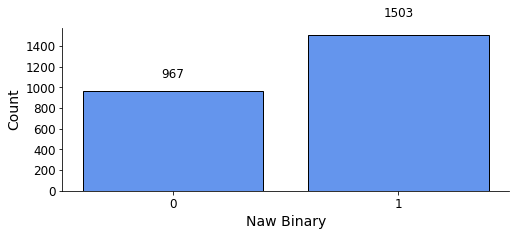

In [55]:
plot_mood_bar(bw_targets,"naw_binary")

# Feature Engineering
In these next cells we will accomplish a few things:
* Check how primary IEQ dataset varies when including mood scores
* Merge datasets
* Principal Component Analysis
    1. IEQ and FB sleep dataset
    2. IEQ and BW sleep dataset
* Clusting 
    1. IEQ and FB sleep dataset
    2. IEQ and BW sleep dataset

## Feature Set Inpection
We inspect the feature sets to see how they change when we include both the IEQ and mood parameters.

### IEQ + Mood Feature Sets Only
The IEQ dataset includes the primary features, but we might want to include mood because these can be important parameters that affect sleep outcomes. Here we see how the dataset shrinks when merging the two feature sets.

In [219]:
ieq_and_mood_features = ieq_features.merge(right=mood_features,on=["beiwe","start_time","end_time"])
print("Observations in IEQ dataset:\t", len(ieq_features))
print("Observations in Mood dataset:\t", len(mood_features))
print("Observations from combined:\t",len(ieq_and_mood_features))

Observations in IEQ dataset:	 332
Observations in Mood dataset:	 736
Observations from combined:	 101


<div class="alert alert-block alert-warning">
 
We lose over 1/3 of our dataset when including the mood features, but this is from _just_ the feature sets. The amount of data loss might be considerably less if we look at the feature sets _after_ they have been merged with the target sets. 
    
</div>

### Feature Sets + Fitbit Sleep Targets
We do the same analysis as above but now after the feature sets have been merged with the Fitbit target set.

In [220]:
ieq_and_fb = ieq_features.merge(right=fb_targets,on=["beiwe","start_time","end_time"])
mood_and_fb = mood_features.merge(right=fb_targets,on=["beiwe","start_time","end_time","end_date"])
ieq_mood_and_fb = ieq_and_fb.merge(right=mood_and_fb,on=["beiwe","start_time","end_time","end_date"])
print("Observations in IEQ dataset merged with FB:\t", len(ieq_and_fb))
print("Observations in Mood dataset merged with FB:\t", len(mood_and_fb))
print("Observations from combined merged sets:\t\t",len(ieq_mood_and_fb))

Observations in IEQ dataset merged with FB:	 281
Observations in Mood dataset merged with FB:	 736
Observations from combined merged sets:		 101


<div class="alert alert-block alert-warning">
 
We still lose nearly 1/3 of our feature set when including mood. Perhaps, at least for this initial inspection, we neglect the effects of mood on sleep outcomes. 
    
</div>

### Feature Sets + Self-Report Sleep Targets
We do the same analysis as above but now after the feature sets have been merged with the Beiwe sleep target set.

In [221]:
ieq_and_bw = ieq_features.merge(right=bw_targets,on=["beiwe","date"])
mood_and_bw = mood_features.merge(right=bw_targets,left_on=["beiwe","end_date"],right_on=["beiwe","date"])
ieq_mood_and_bw = ieq_and_bw.merge(right=mood_and_bw,left_on=["beiwe","date"],right_on=["beiwe","end_date"])
print("Observations in IEQ dataset merged with BW:\t", len(ieq_and_bw))
print("Observations in Mood dataset merged with BW:\t", len(mood_and_bw))
print("Observations from combined merged sets:\t\t",len(ieq_mood_and_bw))

Observations in IEQ dataset merged with BW:	 192
Observations in Mood dataset merged with BW:	 207
Observations from combined merged sets:		 32


## Datasets
We have two datasets that have already been created in the analysis above:
1. IEQ + FB
2. IEQ + Beiwe

### IEQ + FB

In [222]:
ieq_and_fb.dropna(inplace=True)
ieq_and_fb.head()

,start_time,end_time,beiwe,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,date,end_date,efficiency,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary,rem2nrem_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,lkkjddam,126.658333,10.359917,1600.754959,0.895571,23.337500,33.0,2020-08-10,2020-08-10,91,0.217791,7.883333,42.57,33.43,3,0,1,0,0,1
1,2020-08-11 03:35:00,2020-08-11 12:36:30,lkkjddam,233.566667,6.429275,1628.474180,0.847762,25.000000,34.0,2020-08-11,2020-08-11,96,0.256906,9.016667,21.64,64.36,3,1,2,0,1,1
2,2020-08-12 02:59:30,2020-08-12 10:52:30,lkkjddam,252.016667,10.271850,1596.122408,0.939256,24.000000,33.0,2020-08-12,2020-08-12,93,0.189504,7.883333,33.11,31.89,3,0,1,0,1,0
3,2020-08-14 03:05:00,2020-08-14 11:23:30,lkkjddam,223.700000,7.232700,1301.449844,0.886675,25.000000,33.0,2020-08-14,2020-08-14,90,0.218391,8.300000,49.80,24.20,2,0,1,1,0,1
4,2020-08-15 06:51:30,2020-08-15 11:30:00,lkkjddam,209.600000,10.886100,1274.110350,1.046326,23.333333,34.0,2020-08-15,2020-08-15,97,0.320000,4.633333,8.34,38.66,3,1,0,0,1,1


### IEQ + BW

In [223]:
ieq_and_bw.dropna(inplace=True)
ieq_and_bw.head()

,start_time,end_time,beiwe,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,date,tst,sol,naw,tst_binary,restful_binary,sol_binary,naw_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,lkkjddam,126.658333,10.359917,1600.754959,0.895571,23.337500,33.0,2020-08-10,6.0,15.0,5.0,0,0,1,0
1,2020-08-12 02:59:30,2020-08-12 10:52:30,lkkjddam,252.016667,10.271850,1596.122408,0.939256,24.000000,33.0,2020-08-12,8.0,10.0,3.0,1,1,1,0
2,2020-08-14 03:05:00,2020-08-14 11:23:30,lkkjddam,223.700000,7.232700,1301.449844,0.886675,25.000000,33.0,2020-08-14,8.0,10.0,3.0,1,1,1,0
3,2020-08-16 04:21:30,2020-08-16 11:53:00,lkkjddam,268.650000,10.486333,1319.535880,0.884277,24.000000,34.0,2020-08-16,6.0,20.0,4.0,0,0,1,0
4,2020-08-17 03:00:00,2020-08-17 11:30:30,lkkjddam,327.166667,11.025200,1412.926806,1.113030,23.333333,33.0,2020-08-17,6.0,25.0,2.0,0,0,1,0


And we are interested in grouping the features into simplified bins so that we can simplify the overall model. We will use thresholds/recommendations from the literature to help differentiate the measurements into the correct bins. 

3. IEQ (binned) + FB
4. IEQ (binned) + Beiwe

### IEQ Rating Helper Functions
The functions below help categorize some of the IEQ parameters into multiple categories based on concentration thresholds.

In [224]:
def rate_rh(value):
    """rates the rh concentration"""
    if value > 50:
        return 0
    elif value >= 40:
        return 1
    else:
        return 0

### IEQ and FB - Binned

In [225]:
ieq_and_fb_binned = ieq_and_fb.copy()
ieq_and_fb_binned["co2_median"] = [1 if c <= 1100 else 0 for c in ieq_and_fb["co2_median"]]
ieq_and_fb_binned["co_median"] = [1 if c <= 6 else 0 for c in ieq_and_fb["co_median"]]
ieq_and_fb_binned["tvoc_median"] = [1 if c <= 200 else 0 for c in ieq_and_fb["tvoc_median"]]
ieq_and_fb_binned["temperature_c_median"] = [1 if c <= 27 else 0 for c in ieq_and_fb["temperature_c_median"]]
ieq_and_fb_binned["rh_median"] = ieq_and_fb.apply(lambda x: rate_rh(x["rh_median"]), axis="columns")
ieq_and_fb_binned.drop(["pm2p5_mass_median","date","start_time","end_time","end_date","beiwe",],axis="columns",inplace=True)
ieq_and_fb_binned.head()

,tvoc_median,co_median,co2_median,temperature_c_median,rh_median,efficiency,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary,rem2nrem_binary
0,1,0,0,1,0,91,0.217791,7.883333,42.57,33.43,3,0,1,0,0,1
1,0,0,0,1,0,96,0.256906,9.016667,21.64,64.36,3,1,2,0,1,1
2,0,0,0,1,0,93,0.189504,7.883333,33.11,31.89,3,0,1,0,1,0
3,0,0,0,1,0,90,0.218391,8.300000,49.80,24.20,2,0,1,1,0,1
4,0,0,0,1,0,97,0.320000,4.633333,8.34,38.66,3,1,0,0,1,1


### IEQ and BW - Binned

In [226]:
ieq_and_bw_binned = ieq_and_bw.copy()
ieq_and_bw_binned["co2_median"] = [1 if c <= 1100 else 0 for c in ieq_and_bw["co2_median"]]
ieq_and_bw_binned["co_median"] = [1 if c <= 6 else 0 for c in ieq_and_bw["co_median"]]
ieq_and_bw_binned["tvoc_median"] = [1 if c <= 200 else 0 for c in ieq_and_bw["tvoc_median"]]
ieq_and_bw_binned["temperature_c_median"] = [1 if c <= 27 else 0 for c in ieq_and_bw["temperature_c_median"]]
ieq_and_bw_binned["rh_median"] = ieq_and_bw.apply(lambda x: rate_rh(x["rh_median"]), axis="columns")
ieq_and_bw_binned.drop(["pm2p5_mass_median","date","start_time","end_time","beiwe",],axis="columns",inplace=True)
ieq_and_bw_binned.head()

,tvoc_median,co_median,co2_median,temperature_c_median,rh_median,tst,sol,naw,tst_binary,restful_binary,sol_binary,naw_binary
0,1,0,0,1,0,6.0,15.0,5.0,0,0,1,0
1,0,0,0,1,0,8.0,10.0,3.0,1,1,1,0
2,0,0,0,1,0,8.0,10.0,3.0,1,1,1,0
3,0,0,0,1,0,6.0,20.0,4.0,0,0,1,0
4,0,0,0,1,0,6.0,25.0,2.0,0,0,1,0


## PCA
The first step towards determining the importance of our pre-determined features. We conduct PCS to see if any of the IEQ parameters explains the variability in the model. 

In [227]:
from sklearn.decomposition import PCA

### PCA Functions
Below are a few functions that help construct and visualize the PCA. 

In [228]:
def features_for_pca(df, feature_labels, scale=True):
    """
    Collects features from the original dataframe and scales them
    
    Inputs:
    - df: dataframe with features
    - features_labels: list of strings specifying the columns to pull from df
    - scale: whether or not to scale the values
    
    Returns a dataframe with scaled features
    """
    X = df.copy()
    X = X.loc[:, feature_labels]
    if scale:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        
    return X

In [229]:
def run_pca(X):
    """
    Take a feature set, performs PCA, and returns the formatted results
    
    Returns a dataframe of the formatted results from PCA
    """
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return loadings, pca

In [67]:
def visualize_pca(loadings, pca):
    """plots a bar chart, cumulative plot, heatmap , and scatter (1st and 2nd) of the pca loadings"""
    fig, axes = plt.subplots(1,4,figsize=(20,5))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    my_cmap = plt.get_cmap("Blues")
    rescale = lambda y: y / np.max(y)
    evr = pca.explained_variance_ratio_
    axes[0].bar(grid, evr, edgecolor="black",color=my_cmap(rescale(evr)))
    axes[0].set(
        xlabel="Principal Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axes[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", linewidth=2,color="black")
    axes[1].set(
        xlabel="Principal Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # Heatmap
    sns.heatmap(loadings,vmin=-1,vmax=1,annot=True,fmt=".2f",square=True,
                linecolor="black",linewidth=1,cmap="coolwarm_r",
                yticklabels=[var.replace("_"," ").title() for var in loadings.index],cbar_kws={"ticks":[-1,-0.5,0,0.5,1]},ax=axes[2])
    plt.yticks(rotation=0)
    # PC1 and PC2
    axes[3].scatter(loadings.iloc[:,0],loadings.iloc[:,1],color="black",s=75)
    axes[3].set_xlabel("1st Principal Component")
    axes[3].set_xlim([-1,1])
    axes[3].set_xticks([-1,-0.5,0,0.5,1])
    axes[3].set_ylabel("2nd Principal Component")
    axes[3].set_ylim([-1,1])
    axes[3].set_yticks([-1,-0.5,0,0.5,1])
    axes[3].spines['right'].set_position(('data', 0))
    axes[3].spines['top'].set_position(('data', 0))
    for loc in ["bottom","left"]:
        axes[3].spines[loc].set_visible(False)
    
    for ax in [axes[0],axes[1]]:
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
    plt.subplots_adjust(wspace=0.4)
    plt.show()
    plt.close()

### PCA: IEQ + Fitbit Dataset

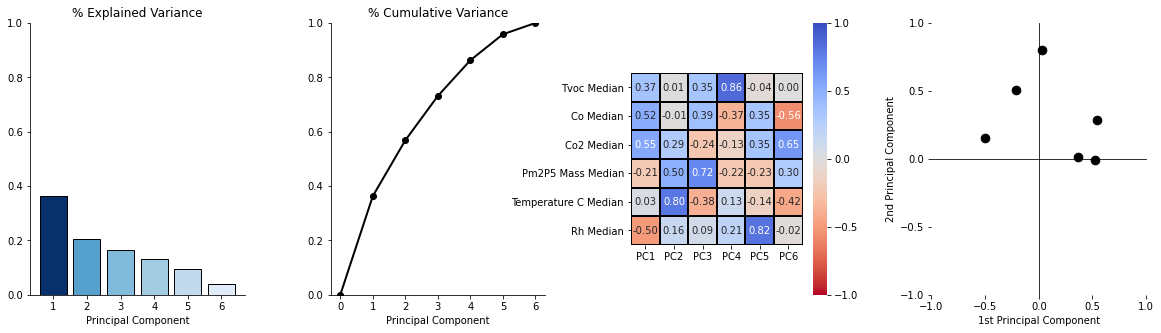

In [68]:
# getting data
feature_labels = ["tvoc_median","co_median","co2_median","pm2p5_mass_median","temperature_c_median","rh_median"]
X = features_for_pca(ieq_and_fb.dropna(), feature_labels=feature_labels, scale=True)
# running pca
loadings_ieq_fb, pca_ieq_fb = run_pca(X)
# displaying results
visualize_pca(loadings_ieq_fb,pca_ieq_fb)

<div class="alert alert-block alert-info">
 
PCA tells us that a considerably amount of the variability is explained by the CO$_2$, RH, and CO measurements. The second PC looks to be dominated by the two measurements that are absent from the first PC which are PM$_{2.5}$ and T. 
    
It would be interesting to see if we clustered the data into two groups, would the groups be defined by the strongest loadings in the first two PCs? 
    
</div>

### PCA: IEQ + Beiwe Dataset

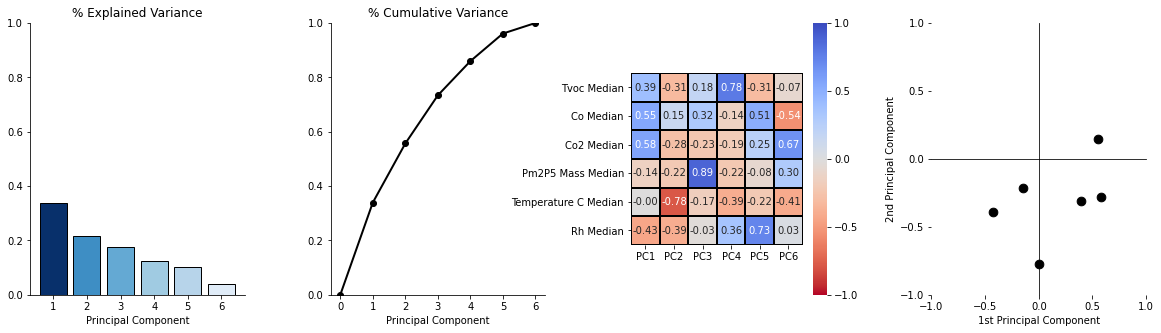

In [69]:
# getting data
feature_labels = ["tvoc_median","co_median","co2_median","pm2p5_mass_median","temperature_c_median","rh_median"]
X = features_for_pca(ieq_and_bw.dropna(), feature_labels=feature_labels, scale=True)
# running pca
loadings_ieq_bw, pca_ieq_bw = run_pca(X)
# displaying results
visualize_pca(loadings_ieq_bw,pca_ieq_bw)

<div class="alert alert-block alert-info">
 
PCA on this dataset tells us nearly the same story as above with a major caveat in the second PC. The temperature loading was positive and nearly 1 while in this analysis, the loading is negative and nearly -1. 
    
Clustering analysis might not prove to be as apparent as in the previous analysis, however would still be interesting. Even more interesting would be to see how these loadings compare to those in the previous dataset.
    
</div>

### Comparing PCA
The target variables are both sleep related but based on two very different types of measurement. Looking at the loadings, there appear to be some similarities and differences that warrant further investigation.

In [70]:
def compare_loadings(loadings1, loadings2, n_components=6):
    """scatters loadings from the specified number of PCs"""
    fig, axes = plt.subplots(1,n_components,figsize=(4*n_components,4),sharey=True)
    for i, ax in enumerate(axes.flat):
        sns.regplot(loadings1.iloc[:,i],loadings2.iloc[:,i],ci=68,ax=ax)
        ax.set_xlim([-1,1])
        ax.set_xlabel("")
        ax.set_ylim([-1,1])
        ax.set_ylabel("")
        r = np.corrcoef(loadings1.iloc[:,i],loadings2.iloc[:,i])
        ax.set_title(f"PC{i+1} r$^2$: {round(r[1,0],2)}",fontsize=14)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        
    ax.set_yticks([-1,-0.5,0,0.5,1])
    plt.show()
    plt.close()

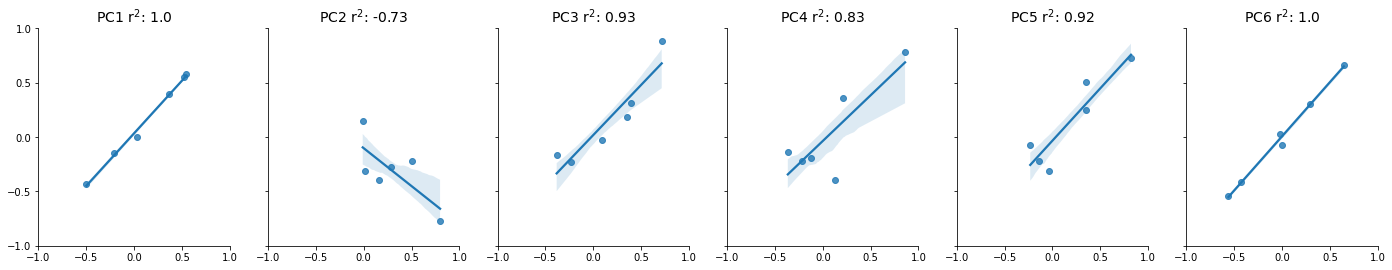

In [71]:
compare_loadings(loadings_ieq_fb,loadings_ieq_bw)

<div class="alert alert-block alert-success">
 
The PC loadings from the previous analyses have excellent agreement barring PC2 which has good, but _negative_ correlation. This PC, in both analyses, is dominated by temperature so perhaps temperature shows opposing outcomes in our target variables. 
    
</div>

## IEQ Clustering
It would be interesting to see if there are any clusters that arise from the data by looking at the median concentrations of our key IEQ parameters for both datasets.

In [72]:
from sklearn.cluster import KMeans

### Important Functions
Like before, some important functions are defined below to help with the analysis.

In [73]:
def get_and_scale_features(df,features,scale=True):
    """gets the features from the df that have a specified aggregate"""
    X = df[features]
    X.dropna(inplace=True)
    if scale:
        return (X-X.min())/(X.max()-X.min())
    
    return X

In [74]:
def elbow(X):
    """plot of sum of squared differences for different ks for elbow method"""
    # getting sum of squared distance for different k
    errors = []
    for k in range(2,11,1):
        model = KMeans(n_clusters=k)
        model.fit(X)
        errors.append(model.inertia_)

    # plotting
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(range(2,11,1),errors,linewidth=2,color="cornflowerblue")
    ## x-axis
    ax.set_xlabel("Number of Clusters",fontsize=16)
    plt.xticks(fontsize=14)
    ## y-axis
    ax.set_ylabel("Sum of Squared Distance",fontsize=16)
    plt.yticks(fontsize=14)
    ## remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    plt.show()
    plt.close()

In [75]:
def create_model(X, k=3):
    kmeans = KMeans(n_clusters=k)
    cluster = kmeans.fit(X)
    for c in range(k):
        n_points = len(cluster.labels_[cluster.labels_ == c])
        print(f"Number of points in Cluster {c}: {n_points}")
        
    X["cluster"] = cluster.labels_
    return X

In [76]:
def plot_distributions(X):
    """plots the distributions from the clusters"""
    for var in X.columns:
        if var not in ["cluster"]:
            fig, ax = plt.subplots(figsize=(12,3))
            for c in X_norm["cluster"].unique():
                to_plot = X[X["cluster"] == c]
                sns.kdeplot(to_plot[var],ax=ax,label=c)
            # improving graph
            for loc in ["left","top","right"]:
                ax.spines[loc].set_visible(False)
            ax.set_xlabel("Normalized " + visualize.get_pollutant_label(var.split("_median")[0]))
            ax.set_yticks([])
            ax.set_ylabel("")
            ax.legend(title="Cluster",frameon=False,title_fontsize=12,fontsize=10)

            plt.show()
            plt.close()

### Clustering: IEQ + FB

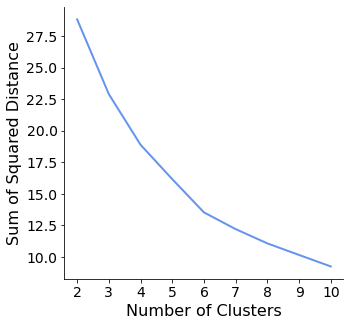

Number of points in Cluster 0: 24
Number of points in Cluster 1: 243


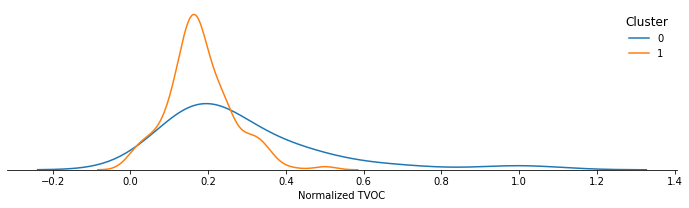

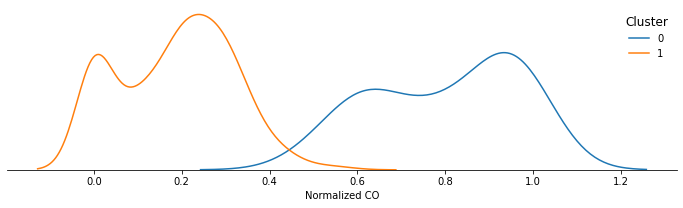

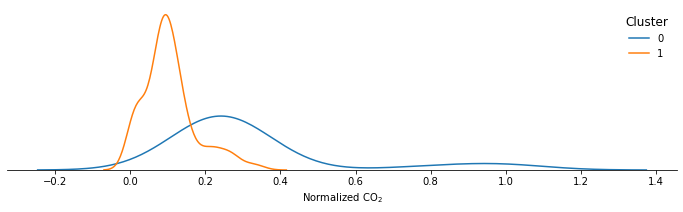

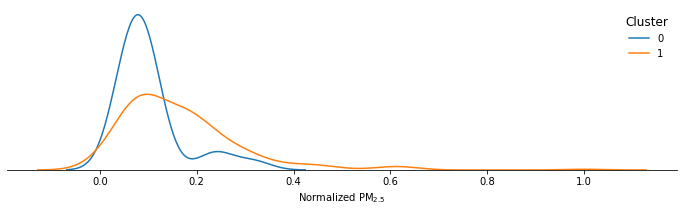

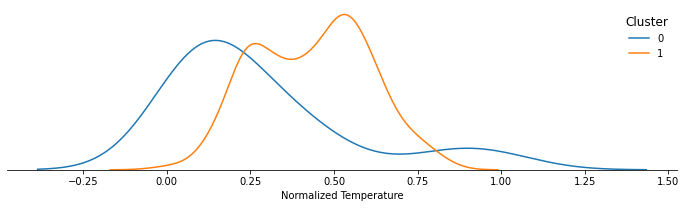

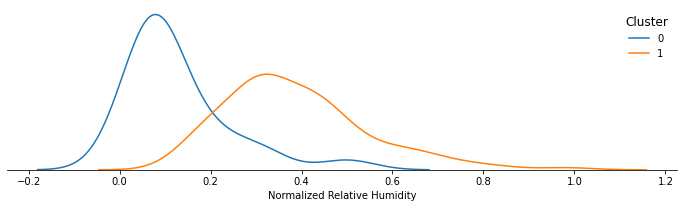

In [77]:
features = [column for column in ieq_and_fb.columns if column.endswith("median")]
X_norm = get_and_scale_features(ieq_and_fb, features)
elbow(X_norm)
X = create_model(X_norm,k=2)
plot_distributions(X)

<div class="alert alert-block alert-info">
 
The clusters seem to be sensitive to the CO concentration primarily and are not evenly split.
    
</div>

### Clustering: IEQ + BW

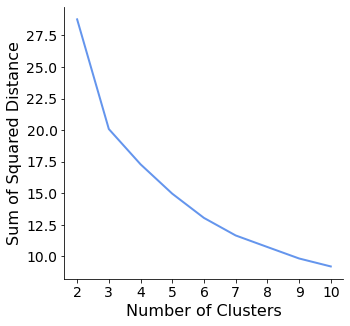

Number of points in Cluster 0: 91
Number of points in Cluster 1: 93


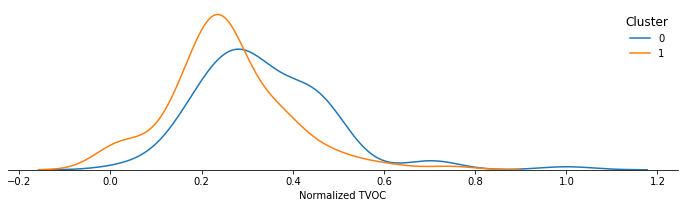

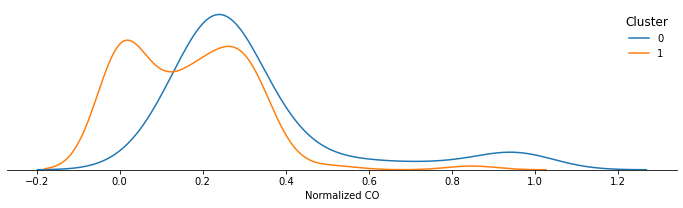

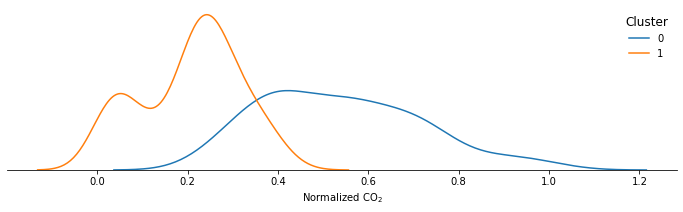

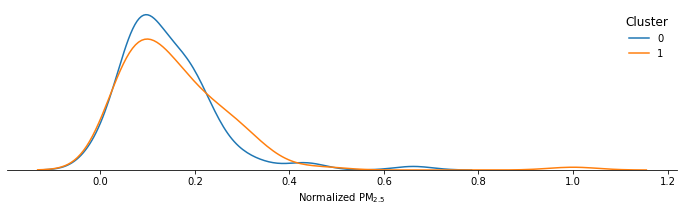

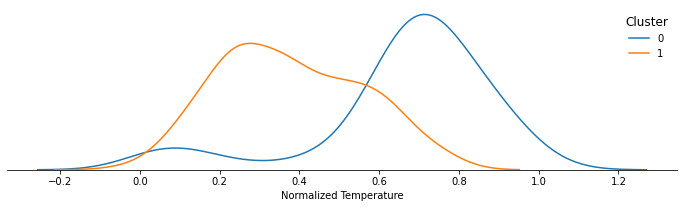

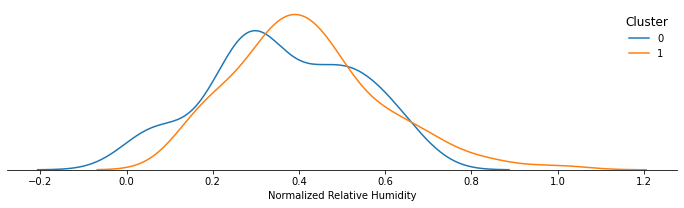

In [78]:
features = [column for column in ieq_and_bw.columns if column.endswith("median")]
X_norm = get_and_scale_features(ieq_and_bw, features)
elbow(X_norm)
X = create_model(X_norm,k=2)
plot_distributions(X)

<div class="alert alert-block alert-info">
 
These clusters seem to be dictated by the `co2` and `temperature_c`.
    
</div>

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. The process will involve an iterative approach where we build a model with one feature, tune the model to get the best accuracy, and then incorporate another feature, re-tune the model, and see if this feature improves the accuracy of the model. We will continue in this way until we arrive at the most accurate model for sleep prediction.

The features that seem the most relevant are listed below _in order of importance_ based on the previous analysis:
1. CO$_2$: `co2` had the largest loading in both PC1s from the IEQ + Fitbit and IEQ + Beiwe datasets. Additionally, we can trust the measurements from these sensors more since they have been vetted and well-calibrated.
2. RH: While `rh` had the third highest loadings in both PC1s, the measurement from these sensors is more reliable than `co` and seems to have a large effect on the clustering analysis for the IEQ + Fitbit dataset.
3. CO: `co` had the second highest loadings in both PC1s and a large influence on the clusters in the IEQ + Fitbit dataset. This variable is not higher on the list because measurements from these sensors seem less reliable.
4. Temperature: `temperature_c` had zero influence on PC1, but was highly important in PC2 and had equal influence on the clusters for both datasets.
5. TVOCs: `tvoc` had somewhat relevant and similar loadings in PC1 for both datasets, but nearly no influence on the clusters for these datasets. Additionally, the measurements from these sensors are suspect which places this variable closer to the bottom.
6. PM$_{2.5}$: The final IEQ variable to consider. The measured values from this sensors do not vary by much, had small loadings in PC1, and did not seem to influence the clustering analysis at all. Quite frankly, this variable might be better left outside of the analysis.

In [79]:
variables = ["co2","rh","co","temperature_c","tvoc","pm2p5_mass"]

## Model Parameters
The majority of our target variables are continuous with the exception of `restful` and `se_rating`. For these variables, we will target a few regressors:
* Generalized Linear Regressor
* Support Vector Regression
* Random Forest Regression

In [80]:
from sklearn.linear_model import TweedieRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

For categorical outcomes, we will target three classifiers:
* Random Forest
* Naive-Bayes

In [146]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Prediction Class

In [164]:
class ieq_and_sq_prediction:
    
    def __init__(self, data, feature_list, target_list):
        self.feature_list = feature_list
        # definining targets/features
        self.data = data
        self.features = data[feature_list]
        self.targets = data[target_list]
        # defining classifier model parameters
        self.classifier_model_params = {
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[5,10,15,20,25],
                    "max_depth":[2,3,4],
                }
            },
            "gnb": {
                "model":GaussianNB(),
                "params": {
                }
            },
            "adaboost": {
                "model":AdaBoostClassifier(random_state=42),
                "params": {
                    "n_estimators":[50,100]
                }
            }
        }
        self.regressor_model_params = {
            "linear": {
                "model":TweedieRegressor(max_iter=5000),
                "params": {
                    "power":[0,1,2],
                }
            },
            "svr": {
                "model":SVR(),
                "params":{
                    "kernel":["poly","rbf"]
                }
            },
            "random_forest": {
                "model":RandomForestRegressor(),
                "params":{
                    "n_estimators":[5,10,15,20,25],
                    "max_depth":[2,3,4]
                }
            }
        }
    
    def target_summary(self, target):
        """prints out a summary of the targets"""
        for score in self.targets[target].unique():
            print(f"{score}: {len(self.targets[self.targets[target] == score])}")
            
    def split_data(self, target, scale=True):
        """splits the data into a training and testing set"""
        if scale:
            for column in self.features.columns:
                self.features[column] = (self.features[column] - self.features[column].min()) / (self.features[column].max() - self.features[column].min())
                
        try:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets[target], test_size=0.33, random_state=10, stratify=self.targets[target])
        except ValueError:
            print("Not a classifier")
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets[target], test_size=0.33, random_state=10)
    
    def optimize_models(self, model_type="classifier"):
        """runs gridsearch cv"""
        try:
            i = 1
            scores = []
            if model_type == "classifier":
                params = self.classifier_model_params
            else:
                params = self.regressor_model_params
            while i < len(self.feature_list)+1:
                for model_name, mp in params.items():
                    clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                    clf.fit(self.X_train[self.feature_list[:i]],self.y_train)
                    scores.append({
                        "model":model_name,
                        "best_score":clf.best_score_,
                        "best_params":clf.best_params_,
                        "n_features":i
                    })
                i+=1

            results = pd.DataFrame(scores,columns=["model","best_score","best_params","n_features"])
            results.sort_values(["best_score"],ascending=False,inplace=True)
            print(f"Highest Scoring Model:")
            best = results.iloc[0,:]
            print(f"\tModel:\t{best[0]}\n\tScore:\t{round(best[1],3)}\n\tParameters:\t{best[2]}\n\tNumber of Features:\t{best[3]}")
            return results.sort_values(["model","n_features"])
        except AttributeError:
            print("Need to split the data first with split_data()")
    
    def train_model(self, model, features_to_include=[]):
        """trains the specified model"""
        self.model = model
        try:
            if len(features_to_include) > 0:
                self.X_train = self.X_train[features_to_include]
                self.X_test = self.X_test[features_to_include]
            self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self, model_type="classifier"):
        """gets the predicted results based on the model provided for the given target"""
        print(self.model)
        try:
            self.predictions = self.model.predict(self.X_test)
            if model_type == "classifier":
                self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

                scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
                print("Cross Validation Scores:")
                for scr in scores:
                    print(f"\t{scr}")
                print(f"Average:{scores.mean()}")
            else:
                self.score = metrics.r2_score(self.y_test,self.predictions)

            print(f"Model Score: {self.score}")
                
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self):
        """plots confusion matrix"""
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)

        plt.show()
        plt.close()
        
    def plot_correlation(self,):
        """Plots the correlation between prediction and true"""
        fig, ax = plt.subplots(figsize=(4,4))
        sns.regplot(x=self.y_test,y=self.predictions,ax=ax)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        ax.set_xlabel("True Values",fontsize=16)

        ax.set_ylabel("Predictions",fontsize=16)

        r = np.corrcoef(self.y_test,self.predictions)
        ax.set_title(f"r$^2$: {round(r[1,0],2)}",fontsize=14)

        plt.show()
        plt.close()

<a id="fitbit-sleep-prediction"></a>

## Fitbit Sleep Targets
We start by trying to predict some of the Fitbit sleep metrics.

In [83]:
fb_prediction = ieq_and_sq_prediction(ieq_and_fb,[var for var in ieq_and_fb.columns if var.endswith("median")],["rem2nrem","rem2nrem_binary","tst_fb","tst_rating","waso","waso_binary","sol_fb","sol_binary","se_binary"])

### TST - Continuous

In [84]:
fb_prediction.split_data("tst_fb")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.029
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	4


Model Score: 0.020556602296498472


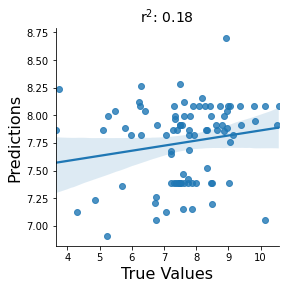

In [85]:
fb_prediction.train_model(RandomForestRegressor(max_depth=2,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### TST - Binned
Looking at the TST values after binning into low (0), typical (1), and high (2) categories.

In [86]:
fb_prediction.split_data("tst_rating")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.596
	Parameters:	{'max_depth': 2, 'n_estimators': 20}
	Number of Features:	6


Cross Validation Scores:
	0.3333333333333333
	0.4820261437908496
	0.3333333333333333
	0.4922077922077922
	0.4126728110599079
Average:0.4107146827450433
Model Score: 0.4289160608063451


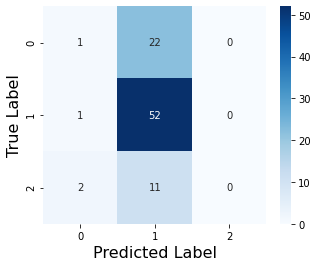

In [87]:
#fb_prediction.train_model(RandomForestClassifier(n_estimators=20,max_depth=2),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.train_model(GaussianNB(),features_to_include=["co2_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### SOL - Continuous

In [88]:
fb_prediction.split_data("sol_fb")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.033
	Parameters:	{'max_depth': 2, 'n_estimators': 15}
	Number of Features:	3


Model Score: -1.8300761756574349


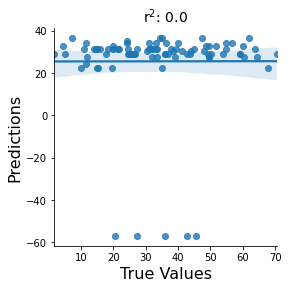

In [89]:
fb_prediction.train_model(RandomForestRegressor(max_depth=2,n_estimators=5),features_to_include=["co2_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### SOL - Binned

In [90]:
fb_prediction.split_data("sol_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.623
	Parameters:	{'max_depth': 2, 'n_estimators': 15}
	Number of Features:	6


Cross Validation Scores:
	0.5774804905239689
	0.6150793650793651
	0.6006060606060606
	0.458128078817734
	0.510204081632653
Average:0.5522996153319564
Model Score: 0.5306586339444116


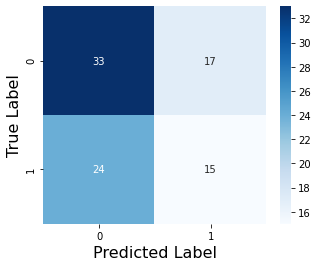

In [91]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### WASO - Continuous

In [92]:
fb_prediction.split_data("waso")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	svr
	Score:	0.115
	Parameters:	{'kernel': 'poly'}
	Number of Features:	5


Model Score: -0.023459721307917736


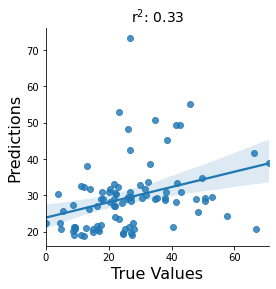

In [93]:
fb_prediction.train_model(RandomForestRegressor(max_depth=4,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### WASO - Binned

In [94]:
fb_prediction.split_data("waso_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.787
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	6


Cross Validation Scores:
	0.6000000000000001
	0.6049382716049383
	0.7287581699346405
	0.8411764705882353
	0.7166666666666667
Average:0.6983079157588963
Model Score: 0.7647940074906366


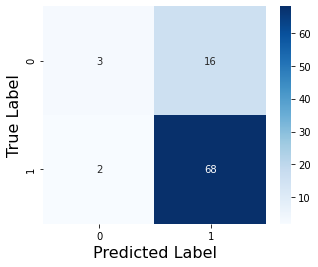

In [95]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=15),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### REM:nREM - Continuous

In [96]:
fb_prediction.split_data("rem2nrem")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.093
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	6


Model Score: 0.17957535546170378


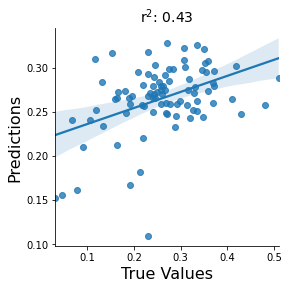

In [97]:
fb_prediction.train_model(SVR(kernel="rbf"),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### REM:nREM - Binary

In [98]:
fb_prediction.split_data("rem2nrem_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.747
	Parameters:	{'max_depth': 2, 'n_estimators': 10}
	Number of Features:	2


Cross Validation Scores:
	0.7323232323232323
	0.5518518518518518
	0.7961138478379858
	0.6428571428571429
	0.719047619047619
Average:0.6884387387835663
Model Score: 0.7981510453705021


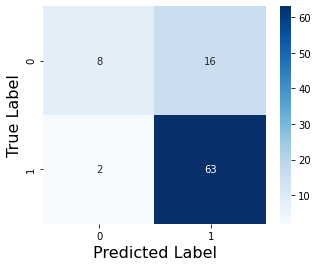

In [99]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### Sleep Efficiency - Binned

In [100]:
fb_prediction.split_data("se_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.882
	Parameters:	{'max_depth': 2, 'n_estimators': 15}
	Number of Features:	3


Cross Validation Scores:
	0.8754208754208753
	0.7415123456790124
	0.7415123456790124
	0.7815126050420168
	0.7783549783549784
Average:0.783662630035179
Model Score: 0.7471910112359551


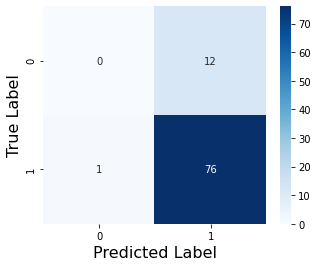

In [101]:
fb_prediction.train_model(RandomForestClassifier(n_estimators=10,max_depth=3),features_to_include=["co2_median","rh_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

<a id="self-report-sleep-prediction"></a>

## Self-Reports Sleep Targets

In [102]:
ieq_and_bw

,start_time,end_time,beiwe,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,date,tst,sol,naw,tst_binary,restful_binary,sol_binary,naw_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,lkkjddam,126.658333,10.359917,1600.754959,0.895571,23.337500,33.000000,2020-08-10,6.0,15.0,5.0,0,0,1,0
1,2020-08-12 02:59:30,2020-08-12 10:52:30,lkkjddam,252.016667,10.271850,1596.122408,0.939256,24.000000,33.000000,2020-08-12,8.0,10.0,3.0,1,1,1,0
2,2020-08-14 03:05:00,2020-08-14 11:23:30,lkkjddam,223.700000,7.232700,1301.449844,0.886675,25.000000,33.000000,2020-08-14,8.0,10.0,3.0,1,1,1,0
3,2020-08-16 04:21:30,2020-08-16 11:53:00,lkkjddam,268.650000,10.486333,1319.535880,0.884277,24.000000,34.000000,2020-08-16,6.0,20.0,4.0,0,0,1,0
4,2020-08-17 03:00:00,2020-08-17 11:30:30,lkkjddam,327.166667,11.025200,1412.926806,1.113030,23.333333,33.000000,2020-08-17,6.0,25.0,2.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2020-08-25 23:46:30,2020-08-26 08:03:00,tlmlq19s,239.100000,2.789250,745.623228,1.075191,26.000000,44.000000,2020-08-26,7.0,20.0,3.0,0,1,1,0
188,2020-08-30 01:30:00,2020-08-30 08:36:30,tlmlq19s,40.325000,2.389450,607.702861,0.938593,27.000000,43.600000,2020-08-30,7.0,15.0,3.0,0,1,1,0
189,2020-08-30 23:42:30,2020-08-31 07:26:00,tlmlq19s,9.500000,1.194650,544.883581,1.861503,25.000000,44.000000,2020-08-31,7.0,10.0,2.0,0,1,1,0
190,2020-06-30 21:17:00,2020-07-01 05:24:30,9xmhtq74,42.050000,3.326200,919.459275,1.612653,28.000000,51.708333,2020-07-01,6.0,10.0,2.0,0,1,1,0


In [103]:
bw_prediction = ieq_and_sq_prediction(ieq_and_bw,[var for var in ieq_and_bw.columns if var.endswith("median")],["tst","tst_binary","sol","sol_binary","naw_binary","restful_binary"])

### TST - Continuous

In [104]:
bw_prediction.split_data("tst")
res = bw_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.111
	Parameters:	{'max_depth': 3, 'n_estimators': 20}
	Number of Features:	5


Model Score: -0.019288553896998017


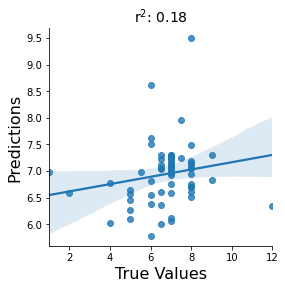

In [105]:
bw_prediction.train_model(RandomForestRegressor(max_depth=3,n_estimators=20),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
bw_prediction.predict(model_type="reg")
bw_prediction.plot_correlation()

### TST - Binned

In [106]:
bw_prediction.split_data("tst_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	gnb
	Score:	0.699
	Parameters:	{}
	Number of Features:	1


Cross Validation Scores:
	0.76
	0.7078787878787878
	0.6457142857142857
	0.4604166666666667
	0.6609848484848485
Average:0.6469989177489178
Model Score: 0.6040983606557377


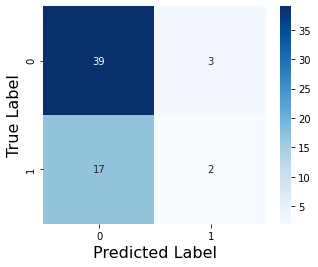

In [107]:
bw_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=15),features_to_include=["co2_median","rh_median","co_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### SOL - Binned

In [108]:
bw_prediction.split_data("sol_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.951
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


Cross Validation Scores:
	0.9216
	0.9216
	0.8433333333333333
	0.9184027777777778
	0.9184027777777778
Average:0.9046677777777777
Model Score: 0.9040580489115828


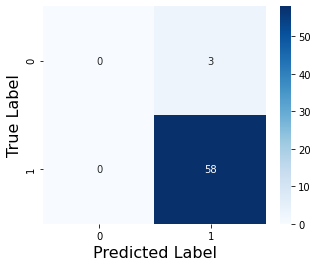

In [109]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=15),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### NAW - Binned

In [110]:
bw_prediction.split_data("naw_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	gnb
	Score:	0.845
	Parameters:	{}
	Number of Features:	6


Cross Validation Scores:
	0.9284210526315789
	0.8704761904761905
	0.7952380952380953
	0.8333333333333334
	0.8523809523809524
Average:0.8559699248120302
Model Score: 0.7081254454739844


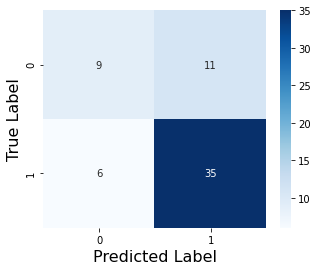

In [111]:
bw_prediction.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### Restful

In [112]:
bw_prediction.split_data("restful_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.895
	Parameters:	{'max_depth': 4, 'n_estimators': 5}
	Number of Features:	3


Cross Validation Scores:
	0.7744
	0.7
	0.7056
	0.765625
	0.765625
Average:0.74225
Model Score: 0.8988607946651848


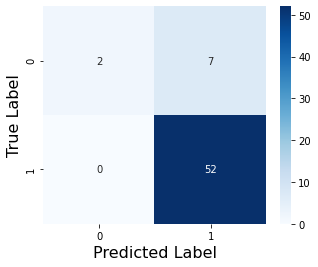

In [113]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=20),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

<a id="prediction_encoded"></a>

# Prediction with Encoded Features
Here we repeat a large portion of the analysis, but considering features that have been encoded.

## Fitbit Sleep Targets

In [165]:
fb_prediction = ieq_and_sq_prediction(ieq_and_fb_binned,[var for var in ieq_and_fb_binned.columns if var.endswith("median")],["rem2nrem_binary","tst_rating","waso_binary","sol_binary","se_binary"])

### TST

In [129]:
fb_prediction.split_data("tst_rating")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.601
	Parameters:	{'max_depth': 4, 'n_estimators': 20}
	Number of Features:	5


Cross Validation Scores:
	0.5607553366174056
	0.449820788530466
	0.389336917562724
	0.43775510204081625
	0.45494505494505494
Average:0.4585226399392933
Model Score: 0.49380370125578327


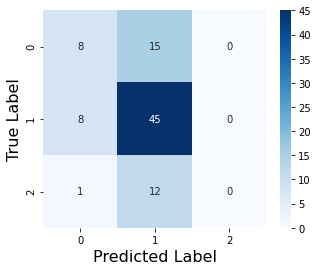

In [127]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=20,random_state=42),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### REM:nREM

In [117]:
fb_prediction.split_data("rem2nrem_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.736
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	4


Cross Validation Scores:
	0.8300653594771242
	0.6222222222222222
	0.5158730158730159
	0.6428571428571429
	0.7569786535303777
Average:0.6735992787919767
Model Score: 0.7121753172906337


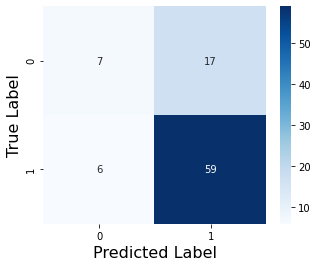

In [118]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### WASO

In [166]:
fb_prediction.split_data("waso_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.781
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


RandomForestClassifier(max_depth=3, n_estimators=4)
Cross Validation Scores:
	0.6049382716049383
	0.6049382716049383
	0.6049382716049383
	0.5951020408163266
	0.6951612903225806
Average:0.6210156291907444
Model Score: 0.8536712829892867


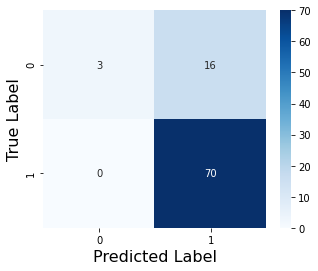

In [167]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=4),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### SOL

In [121]:
fb_prediction.split_data("sol_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.595
	Parameters:	{'max_depth': 3, 'n_estimators': 25}
	Number of Features:	4


Cross Validation Scores:
	0.5774804905239689
	0.6161616161616161
	0.7239583333333334
	0.5840336134453782
	0.5464535464535465
Average:0.6096175199835686
Model Score: 0.45890185296690567


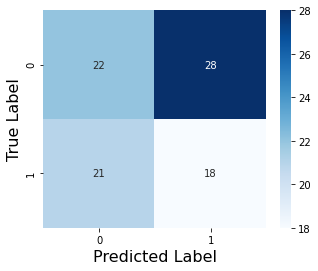

In [122]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### Sleep Efficiency

In [123]:
fb_prediction.split_data("se_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.877
	Parameters:	{'max_depth': 4, 'n_estimators': 25}
	Number of Features:	4


Cross Validation Scores:
	0.8333333333333334
	0.7415123456790124
	0.7415123456790124
	0.7844897959183673
	0.7815126050420168
Average:0.7764720851303484
Model Score: 0.8544551868304155


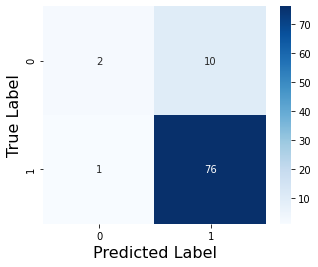

In [124]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

## Beiwe Self-Report Sleep

In [168]:
bw_prediction = ieq_and_sq_prediction(ieq_and_bw_binned,[var for var in ieq_and_bw_binned.columns if var.endswith("median")],["tst_binary","sol_binary","restful_binary","naw_binary"])

### TST

In [135]:
bw_prediction.split_data("tst_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.699
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


Cross Validation Scores:
	0.5184
	0.46240000000000003
	0.46240000000000003
	0.5017361111111112
	0.5017361111111112
Average:0.48933444444444446
Model Score: 0.47406611126041387


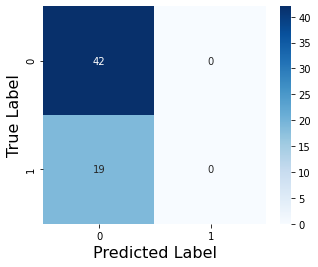

In [137]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=5,random_state=42),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### SOL

In [138]:
bw_prediction.split_data("sol_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.951
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


Cross Validation Scores:
	0.9216
	0.9216
	0.8464
	0.9184027777777778
	0.9184027777777778
Average:0.9052811111111112
Model Score: 0.9040580489115828


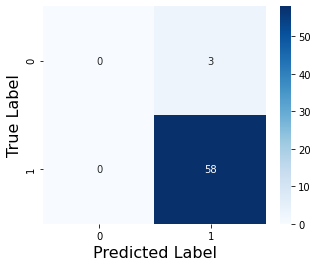

In [139]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=5,random_state=42),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### Restful

In [182]:
bw_prediction.split_data("restful_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.862
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


In [183]:
res

,model,best_score,best_params,n_features
2,adaboost,0.862000,{'n_estimators': 50},1
5,adaboost,0.854000,{'n_estimators': 50},2
8,adaboost,0.854000,{'n_estimators': 50},3
11,adaboost,0.861667,{'n_estimators': 50},4
14,adaboost,0.836667,{'n_estimators': 50},5
1,gnb,0.862000,{},1
4,gnb,0.853667,{},2
7,gnb,0.853667,{},3
10,gnb,0.853667,{},4
13,gnb,0.853667,{},5


AdaBoostClassifier()
Cross Validation Scores:
	0.7744
	0.7056
	0.7056
	0.7556818181818182
	0.7608695652173912
Average:0.7404302766798418
Model Score: 0.7266863746304756


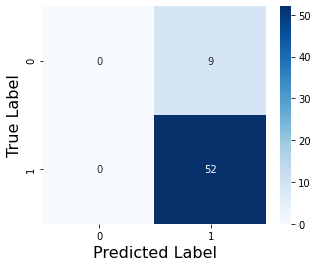

In [185]:
bw_prediction.train_model(AdaBoostClassifier(n_estimators=50),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### NAW

In [144]:
bw_prediction.split_data("naw_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.772
	Parameters:	{'max_depth': 3, 'n_estimators': 5}
	Number of Features:	5


Cross Validation Scores:
	0.92
	0.5447619047619047
	0.7353846153846155
	0.7185185185185187
	0.8055555555555555
Average:0.7448441188441188
Model Score: 0.7225668291242061


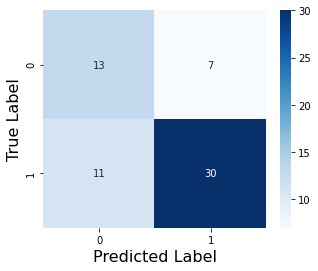

In [145]:
bw_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=5,random_state=42),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

# Review on Current Analysis and Next Steps
After running curating the features and targets, training and tunining models, and predicting some sleep outcomes, I have come to a conclusion about which data are important to include from the feature and target datasets.

## Features
For features we will simply include:
* CO$_2$
* Relative Humidity
* Temperature

We choose to include these because `co2` will give us an indication of ventilation and therefore other pollutant concentrations while `temperature_c` and `rh` give insight into the thermal conditions in the space. These variables also ranked highly in PCA and we can trust their measurements.

## Targets
For targets, we will look at:
* Sleep Efficiency (Fitbit)
* REM:nREM (Fitbit)
* SOL (Fitbit and Beiwe)
* Restfulness (Beiwe)

The other target variables (`tst`, `waso`, and `naw`) are either not heavily affected by IEQ parameters or are more/less incorporated into the other metrics. 

For both datasets, we will be considering binned values i.e. no continuous measurements will be used, only categorical. 

In [186]:
ieq_and_fb_binned

,tvoc_median,co_median,co2_median,temperature_c_median,rh_median,efficiency,rem2nrem,tst_fb,waso,sol_fb,se_rating,se_binary,tst_rating,sol_binary,waso_binary,rem2nrem_binary
0,1,0,0,1,0,91,0.217791,7.883333,42.57,33.43,3,1,1,0,0,1
1,0,0,0,1,0,96,0.256906,9.016667,21.64,64.36,3,1,2,0,1,1
2,0,0,0,1,0,93,0.189504,7.883333,33.11,31.89,3,1,1,0,1,0
3,0,0,0,1,0,90,0.218391,8.300000,49.80,24.20,2,0,1,1,0,1
4,0,0,0,1,0,97,0.320000,4.633333,8.34,38.66,3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1,1,1,0,0,83,0.154286,8.116667,82.79,0.21,1,0,1,1,0,0
277,1,1,1,0,1,89,0.066092,7.350000,48.51,21.49,2,0,1,1,0,0
278,0,1,1,1,0,87,0.191011,8.166667,63.70,2.30,2,0,1,1,0,0
279,1,1,1,1,0,95,0.124060,5.683333,17.05,24.95,3,1,0,1,1,0


## IEQ and Fitbit Sleep Efficiency

In [230]:
ieq_and_se = ieq_and_sq_prediction(ieq_and_fb_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["se_binary"])
ieq_and_se.split_data("se_binary")
res = ieq_and_se.optimize_models()
res

Highest Scoring Model:
	Model:	adaboost
	Score:	0.691
	Parameters:	{'n_estimators': 50}
	Number of Features:	3


,model,best_score,best_params,n_features
2,adaboost,0.600952,{'n_estimators': 50},1
5,adaboost,0.634444,{'n_estimators': 50},2
8,adaboost,0.691111,{'n_estimators': 50},3
1,gnb,0.634762,{},1
4,gnb,0.623810,{},2
7,gnb,0.674127,{},3
0,random_forest,0.600952,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.629524,"{'max_depth': 2, 'n_estimators': 5}",2
6,random_forest,0.679524,"{'max_depth': 3, 'n_estimators': 15}",3


RandomForestClassifier()
Cross Validation Scores:
	0.7442307692307693
	0.39460784313725494
	0.6331018518518519
	0.7441798941798942
	0.5782312925170068
Average:0.6188703301833554
Model Score: 0.6198659238976489


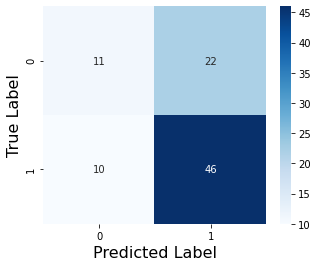

In [237]:
ieq_and_se.train_model(AdaBoostClassifier(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_se.predict()
ieq_and_se.plot_confusion_matrix()

## IEQ and Fitbit REM:nREM Ratio

In [242]:
ieq_and_r2r = ieq_and_sq_prediction(ieq_and_fb_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["rem2nrem_binary"])
ieq_and_r2r.target_summary("rem2nrem_binary")

1: 194
0: 73


In [246]:
194/(73+194)

0.7265917602996255

In [243]:
ieq_and_r2r.split_data("rem2nrem_binary")
res = ieq_and_r2r.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.742
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	3


,model,best_score,best_params,n_features
2,adaboost,0.724762,{'n_estimators': 50},1
5,adaboost,0.724762,{'n_estimators': 50},2
8,adaboost,0.707937,{'n_estimators': 50},3
1,gnb,0.724762,{},1
4,gnb,0.724762,{},2
7,gnb,0.685079,{},3
0,random_forest,0.724762,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.724762,"{'max_depth': 2, 'n_estimators': 5}",2
6,random_forest,0.741587,"{'max_depth': 3, 'n_estimators': 10}",3


RandomForestClassifier(max_depth=3, n_estimators=10)
Cross Validation Scores:
	0.8300653594771242
	0.6222222222222222
	0.5158730158730159
	0.6428571428571429
	0.7569786535303777
Average:0.6735992787919767
Model Score: 0.7121753172906337


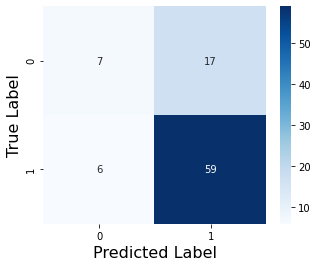

In [245]:
ieq_and_r2r.train_model(RandomForestClassifier(max_depth=3,n_estimators=10),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_r2r.predict()
ieq_and_r2r.plot_confusion_matrix()

## IEQ and Fitbit SOL

In [247]:
ieq_and_fbsol = ieq_and_sq_prediction(ieq_and_fb_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["sol_binary"])
ieq_and_fbsol.target_summary("sol_binary")

0: 151
1: 116


In [248]:
ieq_and_fbsol.split_data("sol_binary")
res = ieq_and_fbsol.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.6
	Parameters:	{'max_depth': 2, 'n_estimators': 10}
	Number of Features:	3


,model,best_score,best_params,n_features
2,adaboost,0.567460,{'n_estimators': 50},1
5,adaboost,0.567460,{'n_estimators': 50},2
8,adaboost,0.589365,{'n_estimators': 50},3
1,gnb,0.567460,{},1
4,gnb,0.550317,{},2
7,gnb,0.589365,{},3
0,random_forest,0.567460,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.538889,"{'max_depth': 2, 'n_estimators': 15}",2
6,random_forest,0.600476,"{'max_depth': 2, 'n_estimators': 10}",3


RandomForestClassifier(max_depth=2, n_estimators=10)
Cross Validation Scores:
	0.5796387520525451
	0.30864197530864196
	0.7239583333333334
	0.6078431372549019
	0.4902597402597402
Average:0.5420683876418325
Model Score: 0.48655142610198787


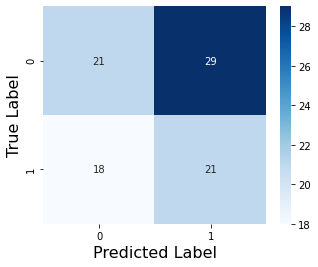

In [251]:
ieq_and_fbsol.train_model(RandomForestClassifier(max_depth=2,n_estimators=10),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_fbsol.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_fbsol.predict()
ieq_and_fbsol.plot_confusion_matrix()

## IEQ and BW Restfulness

In [254]:
ieq_and_restful = ieq_and_sq_prediction(ieq_and_bw_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["restful_binary"])
ieq_and_restful.target_summary("restful_binary")

0: 26
1: 158


In [256]:
ieq_and_restful.split_data("restful_binary")
res = ieq_and_restful.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.862
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


,model,best_score,best_params,n_features
2,adaboost,0.862000,{'n_estimators': 50},1
5,adaboost,0.845333,{'n_estimators': 50},2
8,adaboost,0.828667,{'n_estimators': 50},3
1,gnb,0.862000,{},1
4,gnb,0.845333,{},2
7,gnb,0.796000,{},3
0,random_forest,0.862000,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.862000,"{'max_depth': 2, 'n_estimators': 5}",2
6,random_forest,0.862000,"{'max_depth': 2, 'n_estimators': 10}",3


AdaBoostClassifier()
Cross Validation Scores:
	0.7744
	0.7056
	0.7056
	0.765625
	0.765625
Average:0.74337
Model Score: 0.7266863746304756


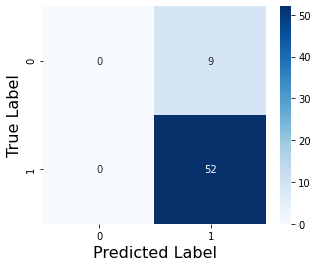

In [258]:
ieq_and_restful.train_model(AdaBoostClassifier(),features_to_include=["co2_median"])
#ieq_and_fbsol.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_restful.predict()
ieq_and_restful.plot_confusion_matrix()